Fitness Fatigue Models Illustrative Code
=========================================

This is a Kaggle Notebook with dependencies on data and scripts hosted on Kaggle.com. To run or edit this notebook, please visit the latest [Kaggle version](https://www.kaggle.com/baogorek/fitness-fatigue-models-illustrative-code).

## Dependencies
 - [example_loads.csv](../input/example-training-loads), a data set of example training loads put together by ... to ...
 - [ffmfunctions.R](../usr/lib/ffmfunctions/ffmfunctions.R), an R script containing functions relevant to the Fitness Fatigue model and variations discussed in our review papers
 

In [1]:
source("../usr/lib/ffmfunctions/ffmfunctions.R")
example_loads <- read.csv('../input/example-training-loads/example_loads.csv')

set.seed(523445)

[1] "Version 7: 2020-12-05-19:07"


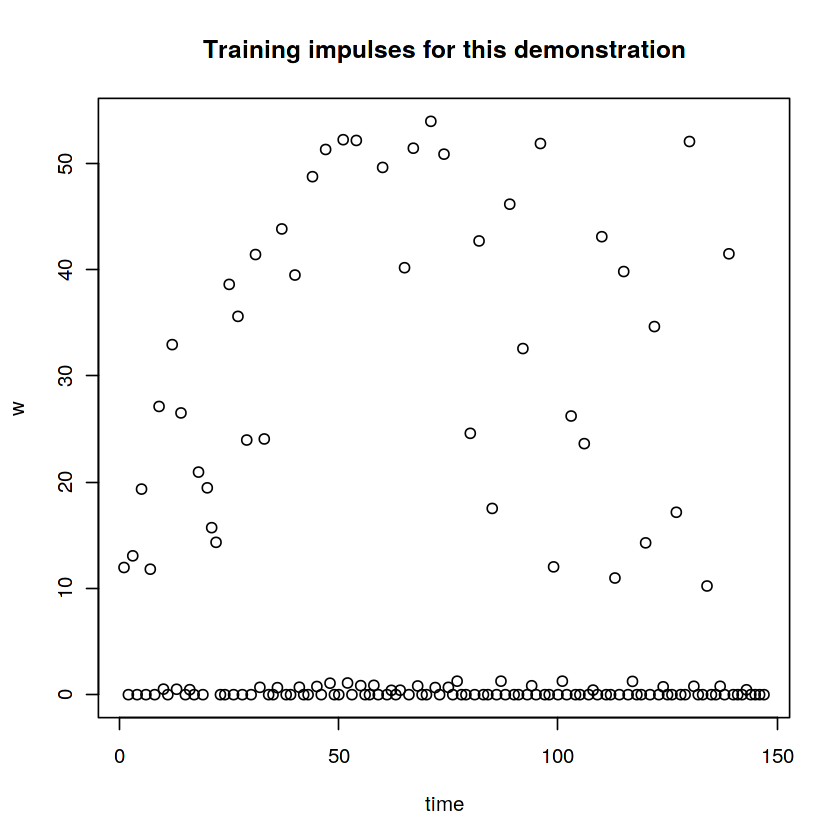

In [2]:
# The Training Plan -----------------------------------------------------------

# "upper body", "lower body", "synthetic"
training_type <- "upper body" 

if (training_type == "synthetic") {
  w <- rep(c(seq(10, 50), rep(20, 14)), 5)
  w <- c(w, rep(0, 100), w)  #  Adding long rest!
} else if (training_type == "upper body") {
  w <- as.numeric(example_loads$tl_upper_fitness)
} else if (training_type == "lower body") {
  w <- as.numeric(example_loads$tl_lower_fitness)
}

plot(w, main = "Training impulses for this demonstration", xlab = "time")

## The Basic FFM

This is the basic 5-parameter Fitness Fatigue Model.

$$
p_n = p_0 + k_g \sum_{i=1}^{n-1} \omega_i \cdot \exp^{-\frac{(n-i)}{\tau_g}}
          - k_h \sum_{i=1}^{n-1} \omega_i \cdot \exp^{-\frac{(n-i)}{\tau_h}}
$$

In [3]:
# Basic FFM -------------------------------------------------------------------
ffm_basic <- create_ffm_model(p_0 = 400, k_g = 1, k_h = 3, tau_g = 60,
                              tau_h = 15, sigma = 20)

print(ffm_basic)


------- Your Fitness Fatigue Model ---------
--- Hill Transform: FALSE , VDR: FALSE , Initial Fitness & Fatigue: FALSE ---

p_n = 400 + 1 * \sum_{i = 1}^{n - 1} w_i * \exp^{-(n - i) / 60 }
          - 3 * \sum_{i = 1}^{n - 1} w_i * \exp^{-(n - i) / 15 }
          + \epsilon_n
where

\epsilon_n ~ N( 0 ,  20 ^ 2)


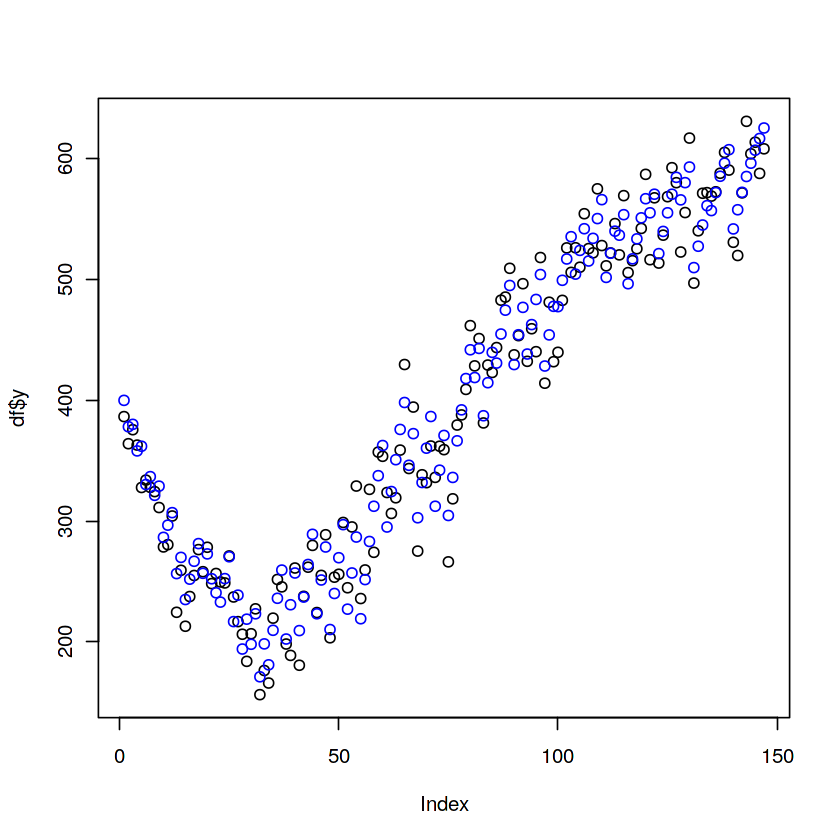

In [4]:
df <- simulate(ffm_basic, w)

# Predictions with true parameters
pred_true_df <- make_predictions(ffm_basic, w)
plot(df$y)
points(pred_true_df$y_hat, col = 'blue')

In [5]:

# Estimating basic model, first get starting values from data set
ffm_from_data <- initialize_ffm_from_data(df, tau_g_seq = c(10, 50, 90),
                                          tau_h_seq = c(5, 10, 20))
print(ffm_from_data)

# Predictions with true parameters
pred_starting_df <- make_predictions(ffm_from_data, w)

The best combination------
  tau_g tau_h tau_h2 delta gamma      p_0       k_g      k_h    sigma
6    90    10     NA    NA    NA 393.0885 0.5678166 3.057406 20.31093

------- Your Fitness Fatigue Model ---------
--- Hill Transform: FALSE , VDR: FALSE , Initial Fitness & Fatigue: FALSE ---

p_n = 393.0885 + 0.5678166 * \sum_{i = 1}^{n - 1} w_i * \exp^{-(n - i) / 90 }
          - 3.057406 * \sum_{i = 1}^{n - 1} w_i * \exp^{-(n - i) / 10 }
          + \epsilon_n
where

\epsilon_n ~ N( 0 ,  20.31093 ^ 2)


In [6]:
# One-shot maximum likelihood using L-BFGS-B
ffm_ml <- maximize_likelihood(ffm_from_data, df)
print(ffm_ml)


Starting L-BFGS-B optimization via optim.
 Depending on the model, this could take 30 seconds or 30 minutes...


------- Your Fitness Fatigue Model ---------
--- Hill Transform: FALSE , VDR: FALSE , Initial Fitness & Fatigue: FALSE ---

p_n = 390.1387 + 0.8198879 * \sum_{i = 1}^{n - 1} w_i * \exp^{-(n - i) / 68.28372 }
          - 2.881069 * \sum_{i = 1}^{n - 1} w_i * \exp^{-(n - i) / 13.39637 }
          + \epsilon_n
where

\epsilon_n ~ N( 0 ,  19.09009 ^ 2)


### Gradient Descent with the 5-parameter FFM
The gradient vector of the sum of squared residuals with respect to the fitness fatigue model is analytically tractible and may be used in a gradient descent algorithm. This method is included for comparison with the L-BFGS-G method used in R's base `optim` function. While it is possible to reduce the error dramatically from an intial condition, scaling is important.

This procedure normalizes the gradient, then applies individual scaling of the parameters before applying the usual $\lambda$ tuning rate parameter. It may be necessary to run the algorithm multiple times with different scalings and values of $\lambda$.

In [7]:
# Demonstration - to get feel for Gradient Descent

ffm_close <- create_ffm_model(p_0 = 385, k_g = .5, k_h = 2.5, tau_g = 52,
                              tau_h = 12, sigma = 15)


ffm_gd <- increase_likelihood_by_gradient(ffm_close, df, reps = 5, lambda = .001)

ffm_gd <- increase_likelihood_by_gradient(ffm_gd, df, reps = 3000, lambda = .01,
                                          thin = 100, parscale = c(.01, 4, 1, .05, .25))

ffm_gd <- increase_likelihood_by_gradient(ffm_gd, df, reps = 1500, lambda = .0001,
                                          thin = 50, parscale = c(.02, 2, .5, .05, .1))


print(ffm_gd)

Rep 1 , Parameters: 385.0002 0.5009696 2.499761 52.00007 11.99946 RMSE: 121.3043 
Rep 2 , Parameters: 385.0004 0.5019392 2.499523 52.00013 11.99892 RMSE: 120.8988 
Rep 3 , Parameters: 385.0006 0.5029089 2.499285 52.0002 11.99837 RMSE: 120.4934 
Rep 4 , Parameters: 385.0008 0.5038786 2.499047 52.00027 11.99783 RMSE: 120.0883 
Rep 5 , Parameters: 385.0011 0.5048483 2.498809 52.00034 11.99729 RMSE: 119.6834 

Raw gradient is -28418.54 -13038264 3200672 -91194.47 728372 
Normalized gradient is -0.002113617 -0.9697153 0.2380486 -0.00678255 0.05417236 
Normalized gradient / parscale is -0.2113617 -0.9697153 0.2380486 -0.0678255 0.5417236 
parscale is 0.01 1 1 0.1 0.1 
lambda is 0.001 

Rep 100 , Parameters: 385.1275 0.7440796 2.443495 52.28112 11.86861 RMSE: 45.35843 
Rep 200 , Parameters: 384.9897 0.933966 3.08891 53.12697 12.13817 RMSE: 26.00613 
Rep 300 , Parameters: 386.0745 1.042204 3.322099 54.23512 12.92362 RMSE: 21.14383 
Rep 400 , Parameters: 387.3347 1.055959 3.239887 54.90196 13.5

FFM with initial values
====

In [8]:
ffm_add_initial <- create_ffm_model(p_0 = 400, k_g = 1, k_h = 3, tau_g = 60,
                                    tau_h = 15, sigma = 20, q_g = 500, q_h = 250)
print(ffm_add_initial)


------- Your Fitness Fatigue Model ---------
--- Hill Transform: FALSE , VDR: FALSE , Initial Fitness & Fatigue: TRUE ---

p_n = 400 + 1 * \sum_{i = 1}^{n - 1} w_i * \exp^{-(n - i) / 60 }
          - 3 * \sum_{i = 1}^{n - 1} w_i * \exp^{-(n - i) / 15 }
          + 500 * \exp ^ {-n  / 60 } + 250 * \exp ^ {-n  / 15 }
          + \epsilon_n
where

\epsilon_n ~ N( 0 ,  20 ^ 2)


In [9]:
df <- simulate(ffm_add_initial, w)
head(df, 5)  # Look for fitness and fatigue to be around their starting values

,t,w,y,y_hat,w_ffm,fitness,fatigue
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,11.97,207.1338,190.1055,11.97,491.7357,233.8767
2,2,0.00,239.3427,205.4062,0.00,495.3802,229.9913
3,3,13.07,258.9814,241.7168,13.07,487.1923,215.1585
4,4,0.00,227.6001,251.4656,0.00,491.9937,213.5094
5,5,19.35,306.2869,284.6432,19.35,483.8617,199.7395


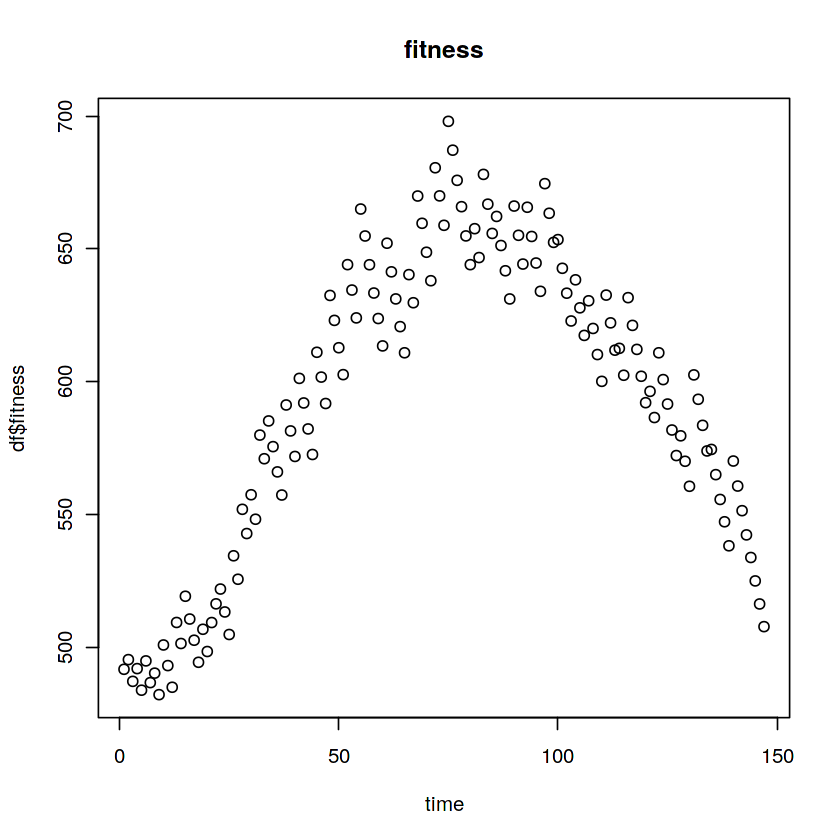

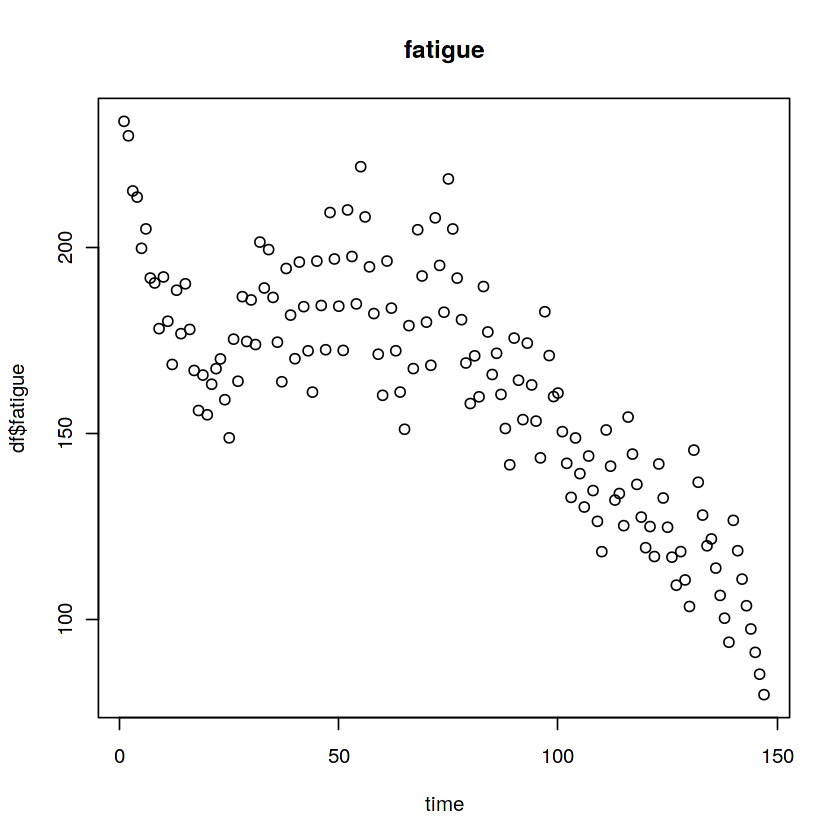

In [10]:
# See the initial values at work
plot(df$fitness, main = "fitness", xlab = "time")
plot(df$fatigue, main = "fatigue", xlab = "time")

In [11]:
ffm_from_data <- initialize_ffm_from_data(df)

The best combination------
  tau_g tau_h tau_h2 delta gamma      p_0       k_g     k_h    sigma
5   100     5     NA    NA    NA 371.9657 0.4144181 1.76343 39.35075


In [12]:
ffm_ml <- maximize_likelihood(ffm_from_data, df, tune_initial = TRUE)
print(ffm_ml)



Tuning Initial parameters (q_g, q_h) with lower bound: 0 0 
  and upper bound: 2071.338 2071.338 
  and starting values: 207.1338 103.5669 

Starting L-BFGS-B optimization via optim.
 Depending on the model, this could take 30 seconds or 30 minutes...


------- Your Fitness Fatigue Model ---------
--- Hill Transform: FALSE , VDR: FALSE , Initial Fitness & Fatigue: TRUE ---

p_n = 647.9736 + 3.176804 * \sum_{i = 1}^{n - 1} w_i * \exp^{-(n - i) / 27.36804 }
          - 5.301906 * \sum_{i = 1}^{n - 1} w_i * \exp^{-(n - i) / 18.10541 }
          + 203.9329 * \exp ^ {-n  / 27.36804 } + 213.1917 * \exp ^ {-n  / 18.10541 }
          + \epsilon_n
where

\epsilon_n ~ N( 0 ,  19.67538 ^ 2)


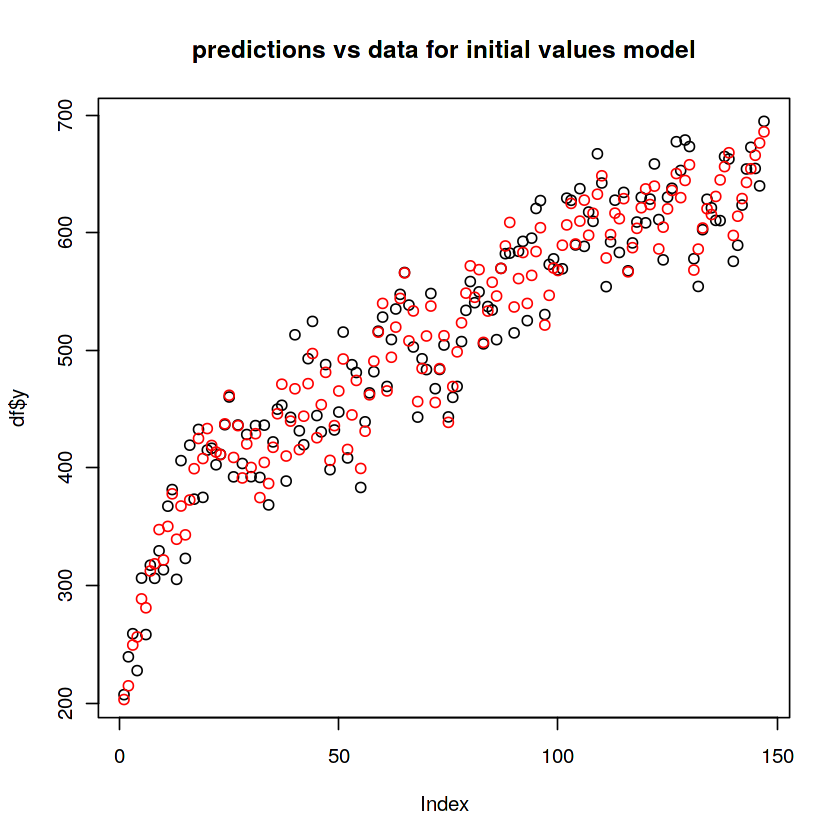

In [13]:
# Predictions with estimated model
pred_df <- make_predictions(ffm_ml, w)
plot(df$y, main = "predictions vs data for initial values model")
points(pred_df$y_hat, col = 'red')

# Estimate VDR Parameters (and initial values)

Fatigue effects can become very large, very fast in the VDR model. Try setting $k_h$ to 3 as in the above examples, and look at the shape of the simulated data.

In [14]:
ffm_vdr <- create_ffm_model(p_0 = 400, k_g = 1, k_h = 1.5, tau_g = 60,
                            tau_h = 15, sigma = 20,
                            tau_h2 = 3, 
                            q_g = 300, q_h = 250)
print(ffm_vdr)


------- Your Fitness Fatigue Model ---------
--- Hill Transform: FALSE , VDR: TRUE , Initial Fitness & Fatigue: TRUE ---

p_n = 400 + 1 * \sum_{i = 1}^{n - 1} w_i * \exp^{-(n - i) / 60 }
          - 1.5 * \sum_{i = 1}^{n - 1} k^i_h2 * \exp^{-(n - i) / 15 }
          + 300 * \exp ^ {-n  / 60 } + 250 * \exp ^ {-n  / 15 }
          + \epsilon_n
where

k^i_h2 = \sum_{j = 1}^i w_i * \exp^{-(i - j) / 3 }

and

\epsilon_n ~ N( 0 ,  20 ^ 2)


In [15]:
df <- simulate(ffm_vdr, w)
head(df, 5)

,t,w,y,y_hat,w_ffm,fitness,fatigue
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,11.97,345.6154,344.2263,11.97,295.0414,233.8767
2,2,0.00,395.5161,373.7470,0.00,301.9370,218.7933
3,3,13.07,356.9971,381.2985,13.07,296.9464,210.4319
4,4,0.00,356.3597,390.2805,0.00,304.8923,209.7412
5,5,19.35,366.5826,391.6873,19.35,299.8529,205.4437


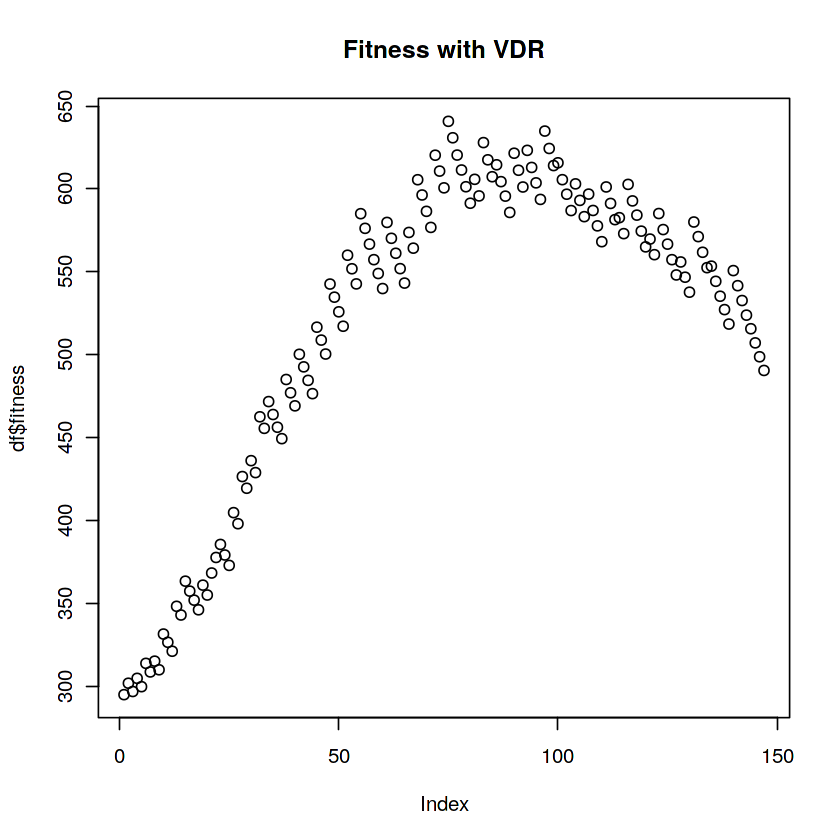

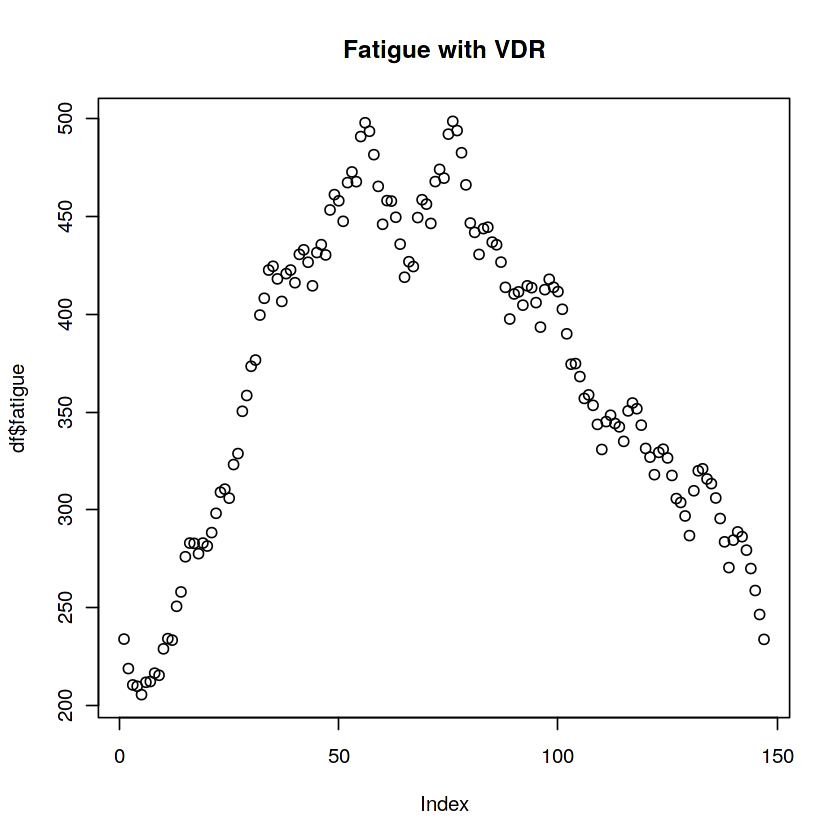

In [16]:
# Fatigue can get pretty large with tau_h and tau_h2
plot(df$fitness, main = "Fitness with VDR")
plot(df$fatigue, main = "Fatigue with VDR")

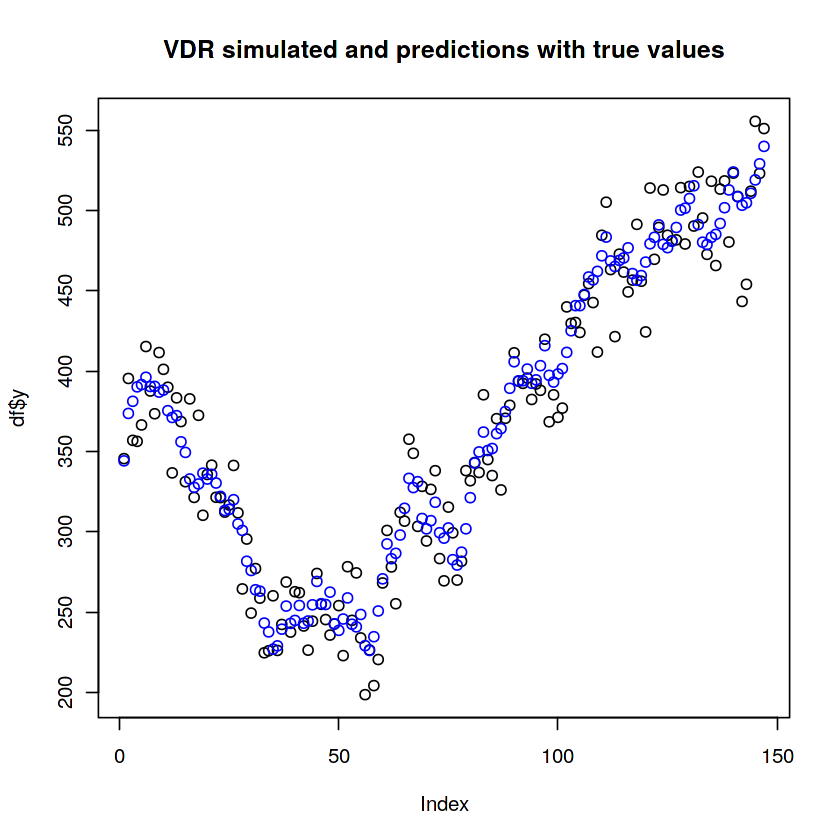

In [17]:
# Predictions with true parameters
pred_true_df <- make_predictions(ffm_vdr, w)
plot(df$y, main = "VDR simulated and predictions with true values")
points(pred_true_df$y_hat, col = 'blue')

In [18]:
# Specify tau_h2_seq for data-driven VDR starting values
ffm_from_data <- initialize_ffm_from_data(df,
                                          tau_g_seq = c(10, 50, 80),
                                          tau_h_seq = c(5, 10, 20),
                                          tau_h2_seq = c(1, 2, 5, 10, 15))

The best combination------
   tau_g tau_h tau_h2 delta gamma      p_0       k_g       k_h    sigma
27    80    20      5    NA    NA 394.8466 0.7248566 0.4711153 25.07454


In [19]:
# One-shot maximum likelihood using L-BFGS-B
ffm_ml <- maximize_likelihood(ffm_from_data, df, tune_initial = TRUE, tune_vdr = TRUE)
print(ffm_ml)



Tuning Initial parameters (q_g, q_h) with lower bound: 0 0 
  and upper bound: 3456.154 3456.154 
  and starting values: 345.6154 172.8077 


Tuning VDR parameter tau_h2 with lower bound: 1 
  and upper bound: 147 
  and starting value: 5 

Starting L-BFGS-B optimization via optim.
 Depending on the model, this could take 30 seconds or 30 minutes...


------- Your Fitness Fatigue Model ---------
--- Hill Transform: FALSE , VDR: TRUE , Initial Fitness & Fatigue: TRUE ---

p_n = 291.6822 + 1.740918 * \sum_{i = 1}^{n - 1} w_i * \exp^{-(n - i) / 56.11709 }
          - 3.196414 * \sum_{i = 1}^{n - 1} k^i_h2 * \exp^{-(n - i) / 21.57933 }
          + 345.6723 * \exp ^ {-n  / 56.11709 } + 173.6391 * \exp ^ {-n  / 21.57933 }
          + \epsilon_n
where

k^i_h2 = \sum_{j = 1}^i w_i * \exp^{-(i - j) / 1.669633 }

and

\epsilon_n ~ N( 0 ,  20.76541 ^ 2)


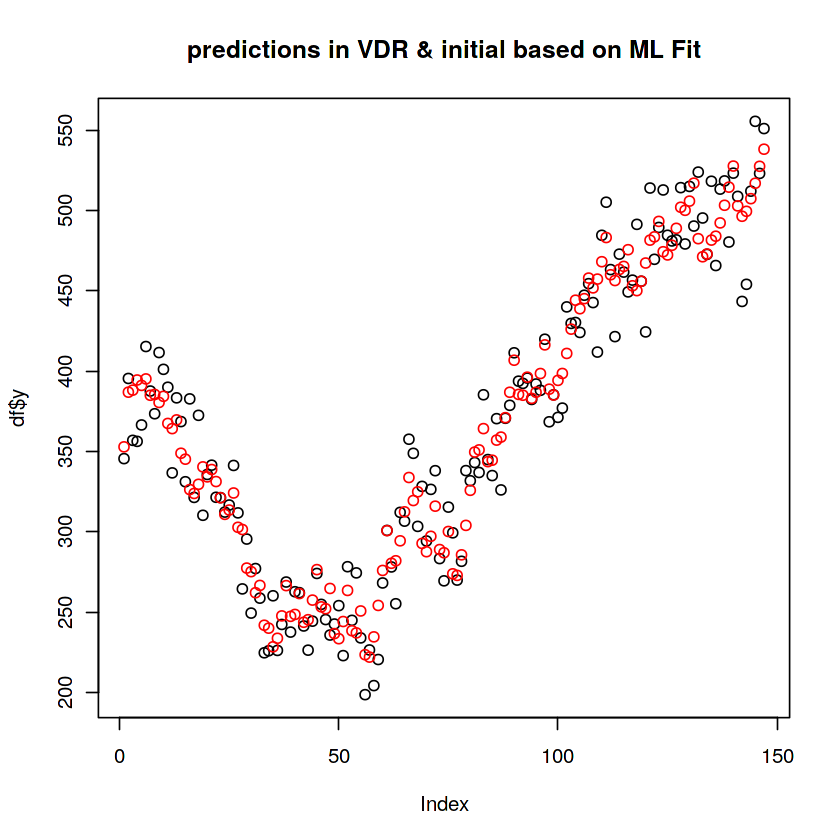

In [20]:
pred_df <- make_predictions(ffm_ml, w)
plot(df$y, main = "predictions in VDR & initial based on ML Fit")
points(pred_df$y_hat, col = 'red')

Hill coefficient estimation
====

In [21]:
ffm_hill <- create_ffm_model(p_0 = 400, k_g = 1, k_h = 3, tau_g = 60,
                             tau_h = 15, sigma = 20,
                             gamma = 2, delta = 10, kappa = 100)
print(ffm_hill)


------- Your Fitness Fatigue Model ---------
--- Hill Transform: TRUE , VDR: FALSE , Initial Fitness & Fatigue: FALSE ---

p_n = 400 + 1 * \sum_{i = 1}^{n - 1} w_i_star * \exp^{-(n - i) / 60 }
          - 3 * \sum_{i = 1}^{n - 1} w_i_star * \exp^{-(n - i) / 15 }
          + \epsilon_n
where

w_i_star = 100 * w_i ^ 2 / ( 10 ^ 2 + w_i ^ 2 )

and

\epsilon_n ~ N( 0 ,  20 ^ 2)


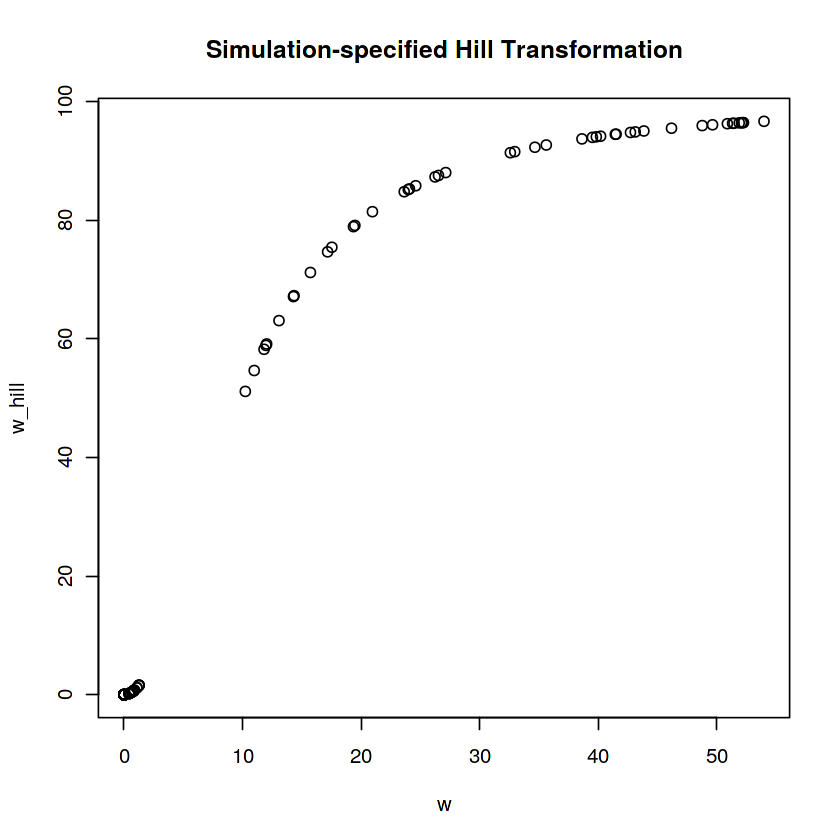

In [22]:
w_hill <- get_hill_transformed_training(ffm_hill, w)
plot(w_hill ~ w, main = "Simulation-specified Hill Transformation")

In [23]:
df <- simulate(ffm_hill, w)
head(df)

,t,w,y,y_hat,w_ffm,fitness,fatigue
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,11.97,387.20457,400.00000,58.89525,0.00000,0.00000
2,2,0.00,321.00735,292.63104,0.00000,57.92180,55.09692
3,3,13.07,305.51323,302.33378,63.07577,56.96444,51.54355
4,4,0.00,211.25361,196.37458,0.00000,118.05612,107.22718
5,5,19.35,213.64234,215.16949,78.92174,116.10482,100.31178
6,6,0.00,99.71801,88.78043,0.00000,191.80306,167.67421


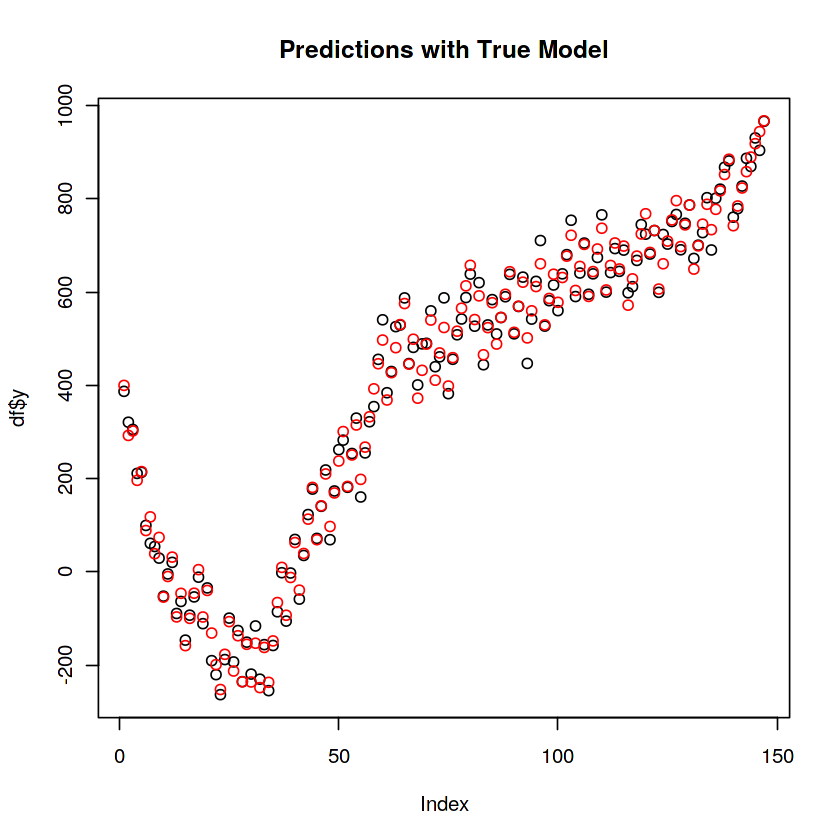

In [24]:
# Predictions with true model
pred_df <- make_predictions(ffm_hill, w)
plot(df$y, main = "Predictions with True Model")
points(pred_df$y_hat, col = 'red')

In [25]:
# Specify delta_seq and gamma_seq for data-driven hill starting values
ffm_from_data <- initialize_ffm_from_data(df,
                                          tau_g_seq = c(10, 50, 80),
                                          tau_h_seq = c(5, 10, 20),
                                          delta_seq = c(.3, 1, 1.5, 5, 20),
                                          gamma_seq = c(.3, 1, 2, 5, 20))
ffm_from_data

The best combination------
    tau_g tau_h tau_h2 delta gamma      p_0     k_g      k_h    sigma
125    50    20     NA     5     2 426.3013 1.46236 3.053949 27.97813



------- Your Fitness Fatigue Model ---------
--- Hill Transform: TRUE , VDR: FALSE , Initial Fitness & Fatigue: FALSE ---

p_n = 426.3013 + 1.46236 * \sum_{i = 1}^{n - 1} w_i_star * \exp^{-(n - i) / 50 }
          - 3.053949 * \sum_{i = 1}^{n - 1} w_i_star * \exp^{-(n - i) / 20 }
          + \epsilon_n
where

w_i_star = 100 * w_i ^ 2 / ( 5 ^ 2 + w_i ^ 2 )

and

\epsilon_n ~ N( 0 ,  27.97813 ^ 2)

In [26]:
# One-shot maximum likelihood using L-BFGS-B
ffm_ml <- maximize_likelihood(ffm_from_data, df, tune_hill = TRUE)
print(ffm_ml)



Tuning Hill parameters (delta, gamma) with lower bound: 0.1 0.1 
  and upper bound: 100 20 
  and starting values: 5 2 

Starting L-BFGS-B optimization via optim.
 Depending on the model, this could take 30 seconds or 30 minutes...


------- Your Fitness Fatigue Model ---------
--- Hill Transform: TRUE , VDR: FALSE , Initial Fitness & Fatigue: FALSE ---

p_n = 397.6268 + 1.024103 * \sum_{i = 1}^{n - 1} w_i_star * \exp^{-(n - i) / 58.652 }
          - 3.038078 * \sum_{i = 1}^{n - 1} w_i_star * \exp^{-(n - i) / 14.94144 }
          + \epsilon_n
where

w_i_star = 100 * w_i ^ 2.101503 / ( 10.19232 ^ 2.101503 + w_i ^ 2.101503 )

and

\epsilon_n ~ N( 0 ,  20.94506 ^ 2)


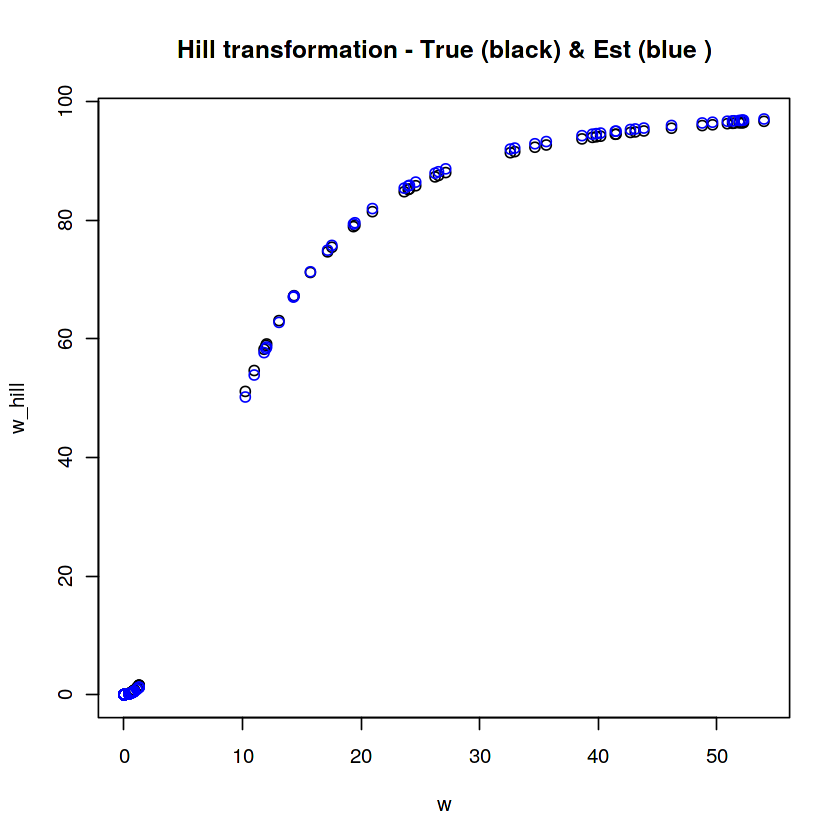

In [27]:
# Hill transformation analysis
w_hill_ml <- get_hill_transformed_training(ffm_ml, w)
plot(w_hill ~ w, 
     main = "Hill transformation - True (black) & Est (blue )")
points(w_hill_ml ~ w, col = 'blue')

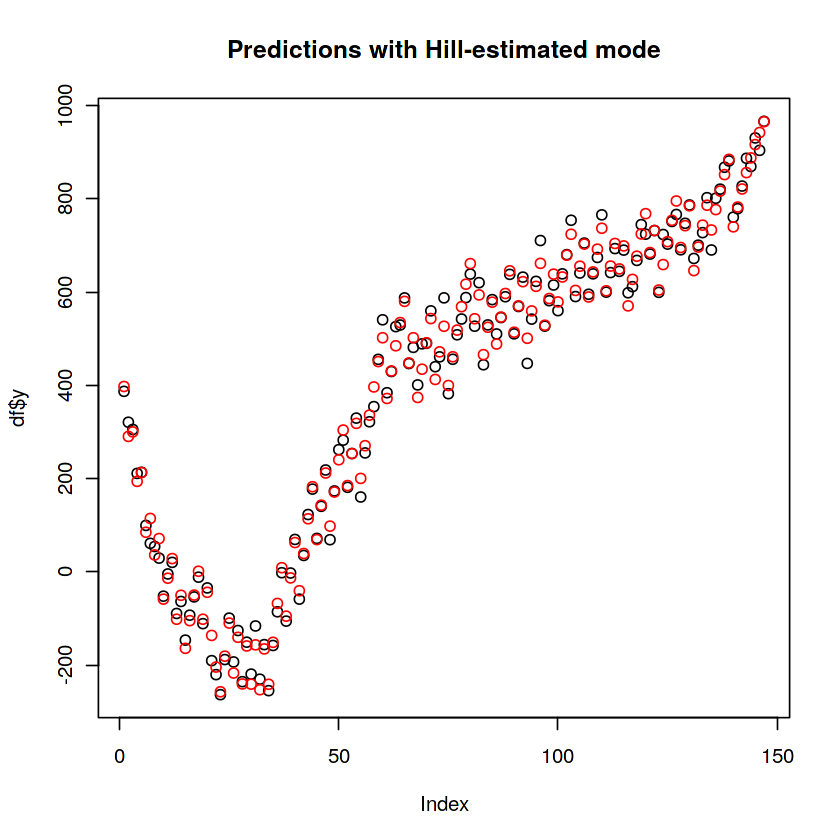

In [28]:
# Predictions with estimated model
pred_df <- make_predictions(ffm_ml, w)
plot(df$y, main = "Predictions with Hill-estimated mode")
points(pred_df$y_hat, col = 'red')

"The Works": VDR, Hill and Initial Value estimation
==========

In [29]:
ffm_the_works <- create_ffm_model(p_0 = 400, k_g = 1, k_h = .9, tau_g = 60,
                                  tau_h = 15, sigma = 20, tau_h2 = 3,
                                  gamma = 2, delta = 10,
                                  q_g = 300, q_h = 250)
print(ffm_the_works)


------- Your Fitness Fatigue Model ---------
--- Hill Transform: TRUE , VDR: TRUE , Initial Fitness & Fatigue: TRUE ---

p_n = 400 + 1 * \sum_{i = 1}^{n - 1} w_i_star * \exp^{-(n - i) / 60 }
          - 0.9 * \sum_{i = 1}^{n - 1} k^i_h2 * \exp^{-(n - i) / 15 }
          + 300 * \exp ^ {-n  / 60 } + 250 * \exp ^ {-n  / 15 }
          + \epsilon_n
where

w_i_star = 100 * w_i ^ 2 / ( 10 ^ 2 + w_i ^ 2 )

and

k^i_h2 = \sum_{j = 1}^i w_i_star * \exp^{-(i - j) / 3 }

and

\epsilon_n ~ N( 0 ,  20 ^ 2)


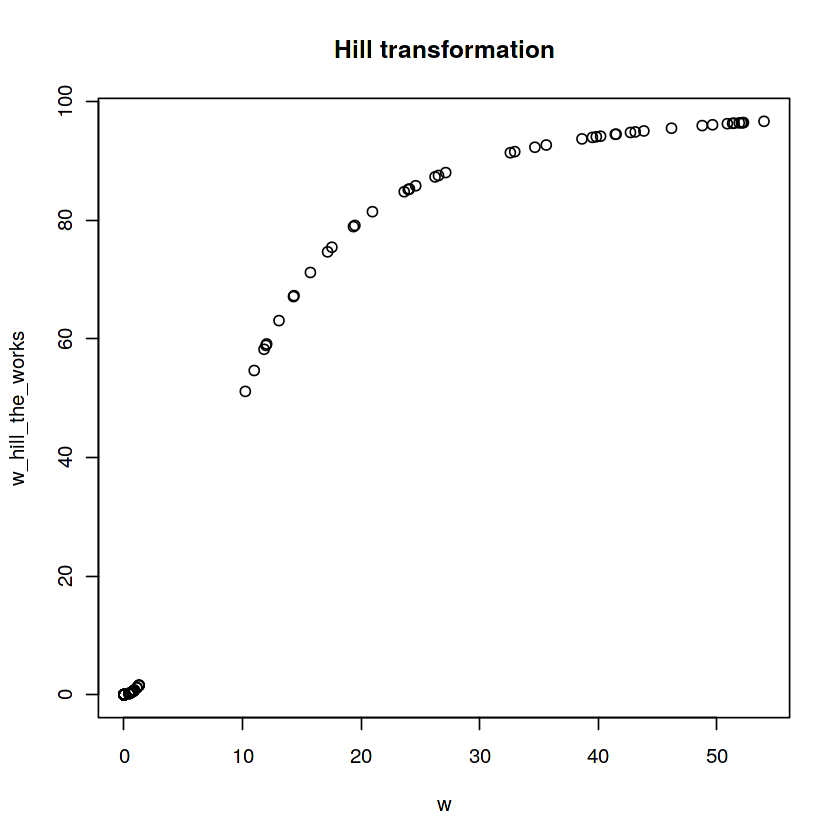

In [30]:
w_hill_the_works <- get_hill_transformed_training(ffm_the_works, w)
plot(w_hill_the_works ~ w, main = "Hill transformation")

In [31]:
df <- simulate(ffm_the_works, w)
head(df)

,t,w,y,y_hat,w_ffm,fitness,fatigue
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,11.97,464.2410,484.5524,58.89525,295.0414,233.8767
2,2,0.00,546.4675,551.1726,0.00000,348.0866,218.7933
3,3,13.07,530.1037,532.6599,63.07577,342.3333,232.9704
4,4,0.00,572.7974,546.2623,0.00000,398.7082,280.4954
5,5,19.35,487.0663,515.6162,78.92174,392.1181,307.2244
6,6,0.00,548.9443,528.0694,0.00000,463.2543,372.4277


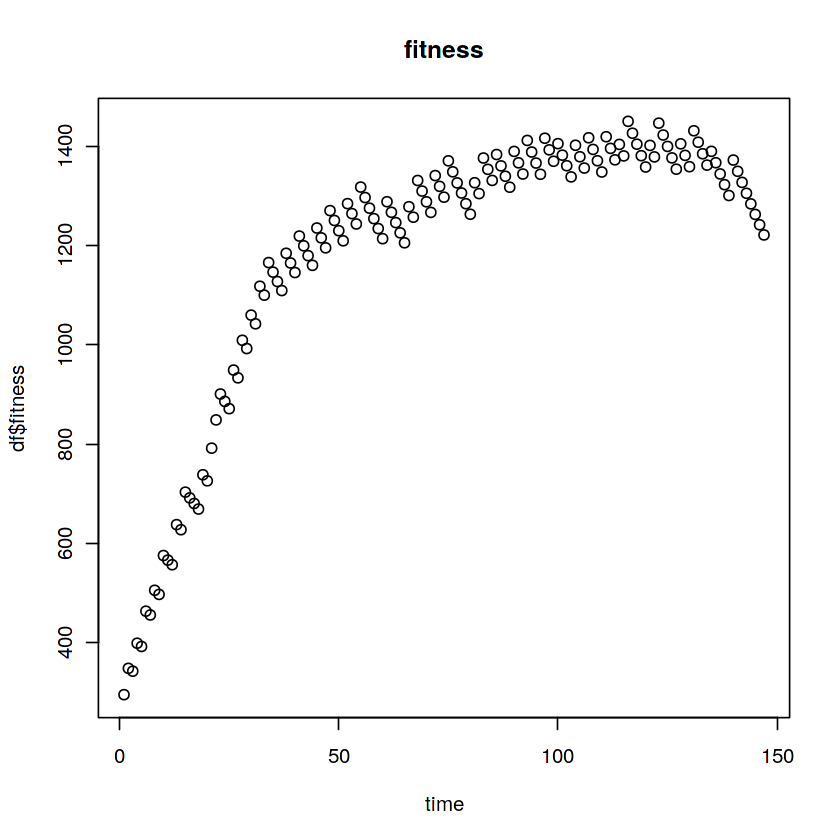

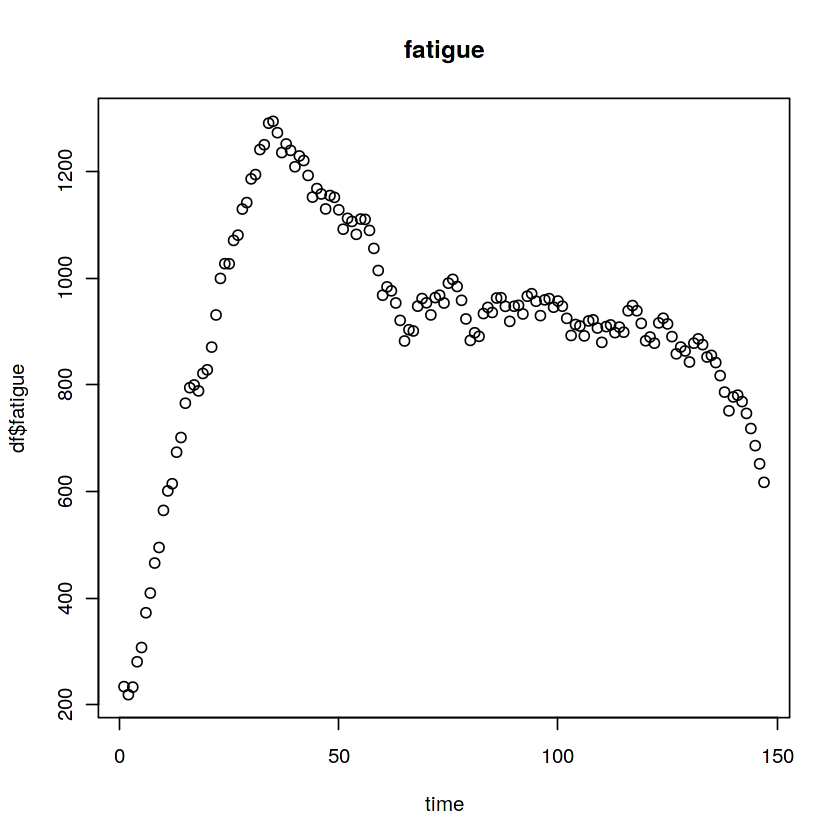

In [32]:
plot(df$fitness, main = "fitness", xlab = "time")
plot(df$fatigue, main = "fatigue", xlab = "time")

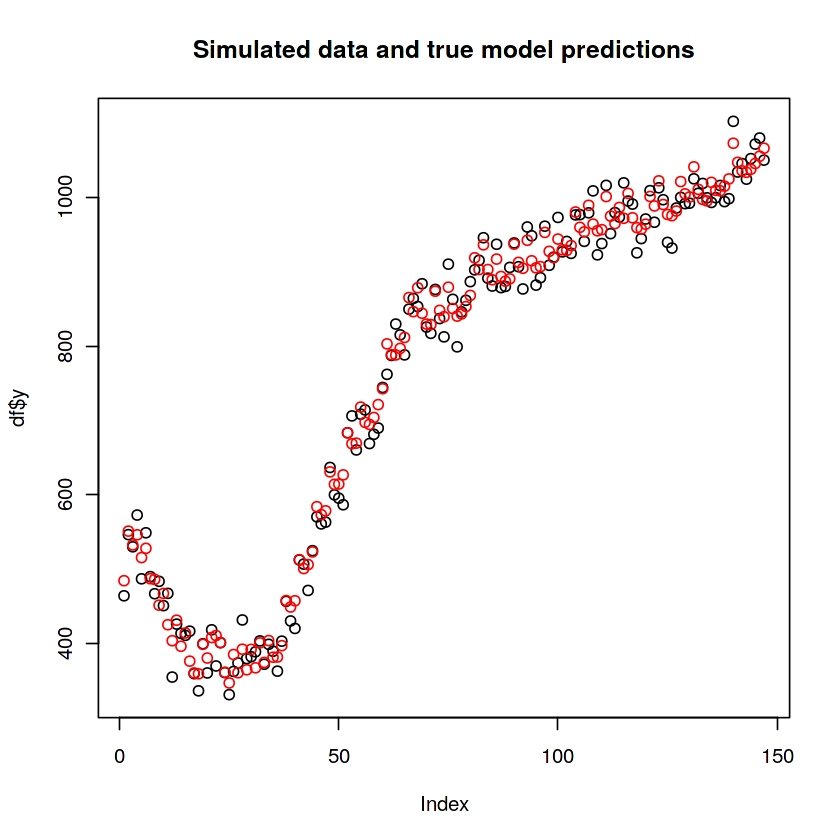

In [33]:
pred_df <- make_predictions(ffm_the_works, w)
plot(df$y, main = "Simulated data and true model predictions")
points(pred_df$y_hat, col = 'red')

In [34]:
ffm_from_data <- initialize_ffm_from_data(df,
                                          tau_g_seq = c(10, 50, 80),
                                          tau_h_seq = c(5, 10, 20),
                                          tau_h2_seq = c(1, 2, 5, 10),
                                          delta_seq = c(.3, 1, 1.5, 5, 20),
                                          gamma_seq = c(.3, 1, 2, 5, 20))

The best combination------
    tau_g tau_h tau_h2 delta gamma      p_0      k_g      k_h    sigma
485    50    20      2     5     2 499.1777 1.205735 1.309755 23.00817


In [35]:
ffm_ml <- maximize_likelihood(ffm_from_data, df, tune_initial = TRUE,
                              tune_vdr = TRUE, tune_hill = TRUE)
print(ffm_ml)



Tuning Initial parameters (q_g, q_h) with lower bound: 0 0 
  and upper bound: 4642.41 4642.41 
  and starting values: 464.241 232.1205 


Tuning Hill parameters (delta, gamma) with lower bound: 0.1 0.1 
  and upper bound: 100 20 
  and starting values: 5 2 


Tuning VDR parameter tau_h2 with lower bound: 1 
  and upper bound: 147 
  and starting value: 2 

Starting L-BFGS-B optimization via optim.
 Depending on the model, this could take 30 seconds or 30 minutes...


------- Your Fitness Fatigue Model ---------
--- Hill Transform: TRUE , VDR: TRUE , Initial Fitness & Fatigue: TRUE ---

p_n = 249.5889 + 0.9555494 * \sum_{i = 1}^{n - 1} w_i_star * \exp^{-(n - i) / 66.46889 }
          - 0.795606 * \sum_{i = 1}^{n - 1} k^i_h2 * \exp^{-(n - i) / 15.7311 }
          + 453.2593 * \exp ^ {-n  / 66.46889 } + 242.7726 * \exp ^ {-n  / 15.7311 }
          + \epsilon_n
where

w_i_star = 100 * w_i ^ 2.945065 / ( 10.07801 ^ 2.945065 + w_i ^ 2.945065 )

and

k^i_h2 = \sum_{j = 1}^i w_i_star * \exp

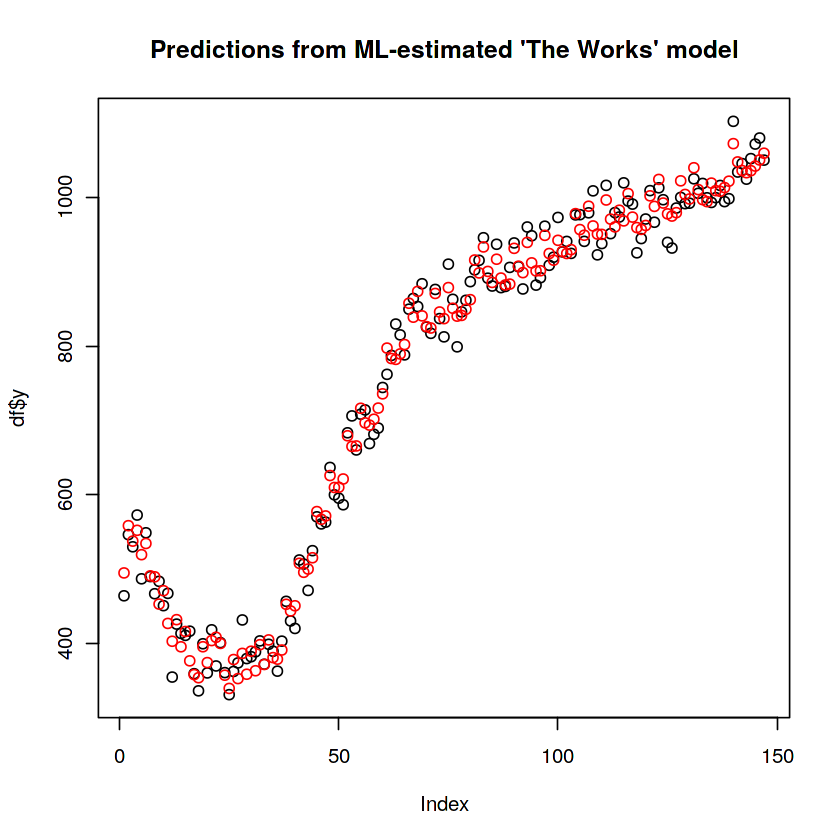

In [36]:
# Predictions with estimated model
pred_df <- make_predictions(ffm_ml, w)
plot(df$y, main = "Predictions from ML-estimated 'The Works' model")
points(pred_df$y_hat, col = 'red')

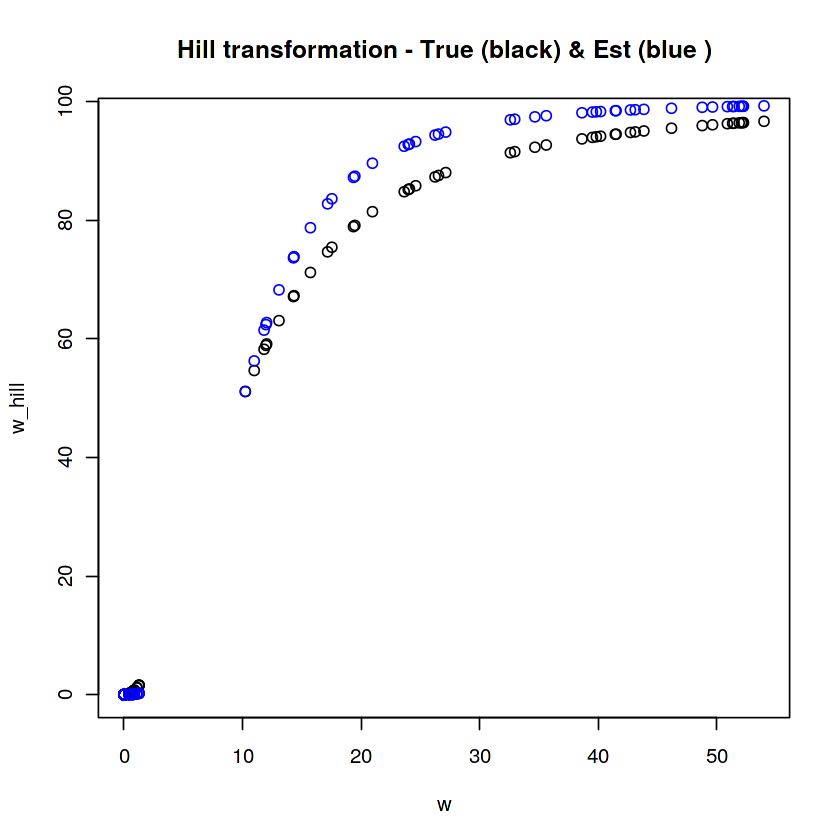

In [38]:
w_hill_ml <- get_hill_transformed_training(ffm_ml, w)
plot(w_hill ~ w, 
     main = "Hill transformation - True (black) & Est (blue )")
points(w_hill_ml ~ w, col = 'blue')